In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [26]:
def duration(pickup_date, dropoff_date, pickup_hr, dropoff_hr, pickup_min, dropoff_min):
    if pickup_date != dropoff_date:
        duration = (((24-pickup_hr) * 60 - pickup_min) + (dropoff_hr*60+dropoff_min))/60.0
    else:
        duration = ((dropoff_hr*60+dropoff_min) - (pickup_hr*60+pickup_min))/60.0
    return duration

In [27]:
def distance(lat1, long1, lat2, long2):
    from geopy.distance import vincenty, great_circle
    from haversine import haversine
    if (lat1 > 30) & (lat1 < 50) & (long1 > -80) & (long1 < -70) & (lat2 > 30) & (lat2 < 50) & (long2 > -80) & (long2 < -70):
        distance = haversine((lat1, long1), (lat2, long2))
        #distance1 = vincenty((lat1, long1), (lat2, long2)).miles
    else:
        distance = 0
        #distnace1 = 0
    return distance

In [28]:
def data_prep(dfinput):
    df=pd.DataFrame()
    df['vendor_532'] = np.where(dfinput.vendor_id == 'DST000532', 1, 0)
    df['vendor_401'] = np.where(dfinput.vendor_id == 'DST000401', 1, 0)
    df['vendor_543'] = np.where(dfinput.vendor_id == 'DST000543', 1, 0)

    df['new_user'] = np.where(dfinput.new_user == 'YES', 1, 0)
    df['new_user_missing'] = np.where(dfinput.new_user.isnull() == True, 1, 0)

    df['toll_amt'] = np.log(dfinput.tolls_amount+2)

    df['tip_missing'] = np.where(dfinput.tip_amount.isnull() == True, 1, 0)
    df['tip_amt'] = np.where(dfinput.tip_amount.notnull() == True, np.log(dfinput.tip_amount+1), 0)

    df['mta_tax'] = [np.abs(dfinput.mta_tax[i]) for i in range(len(dfinput))]
    df['passenger_count'] = dfinput.passenger_count

    df.pickup_datetime = pd.to_datetime(dfinput.pickup_datetime)
    df.dropoff_datetime = pd.to_datetime(dfinput.dropoff_datetime)
    df['pickup_date'] = df.pickup_datetime.dt.date
    df['dropoff_date'] = df.dropoff_datetime.dt.date
    df['pickup_hour'] = df.pickup_datetime.dt.hour
    df['dropoff_hour'] = df.dropoff_datetime.dt.hour
    df['pickup_min'] = df.pickup_datetime.dt.minute
    df['dropoff_min'] = df.dropoff_datetime.dt.minute
    
    df['duration'] = [duration(df['pickup_date'][i], df['dropoff_date'][i], 
                                df['pickup_hour'][i], df['dropoff_hour'][i], 
                                df['pickup_min'][i], df['dropoff_min'][i]) for i in range(len(dfinput))]
    
    df['month'] = df.pickup_datetime.dt.month
    df['weekday'] = df.pickup_datetime.dt.weekday
    df['hour'] = df.pickup_datetime.dt.hour

    df['rate_code_0'] = np.where(dfinput.rate_code == 0, 1, 0)
    df['rate_code_1'] = np.where(dfinput.rate_code == 1, 1, 0)
    df['rate_code_2'] = np.where(dfinput.rate_code == 2, 1, 0)
    df['rate_code_3'] = np.where(dfinput.rate_code == 3, 1, 0)
    df['rate_code_4'] = np.where(dfinput.rate_code == 4, 1, 0)
    df['rate_code_5'] = np.where(dfinput.rate_code == 5, 1, 0)
    df['rate_code_6'] = np.where(dfinput.rate_code == 6, 1, 0)
    df['rate_code_99'] = np.where(dfinput.rate_code == 99, 1, 0)

    df['store_flag'] = np.where(dfinput.store_and_fwd_flag == 'Y', 1, 0)
    df['store_flag_missing'] = np.where(dfinput.store_and_fwd_flag.isnull() == True, 1, 0)

    df['payment_CRD'] = np.where(dfinput.payment_type == 'CRD', 1, 0)
    df['payment_CSH'] = np.where(dfinput.payment_type == 'CSH', 1, 0)
    df['payment_UNK'] = np.where(dfinput.payment_type == 'UNK', 1, 0)
    df['payment_NOC'] = np.where(dfinput.payment_type == 'NOC', 1, 0)

    df['surcharge'] = np.where(((dfinput.surcharge >= 0) & (dfinput.surcharge < 5)) == True, dfinput.surcharge, 0)
    df['distance'] = [distance(dfinput.pickup_latitude[i], dfinput.pickup_longitude[i], dfinput.dropoff_latitude[i], 
                                dfinput.dropoff_longitude[i]) for i in range(len(dfinput))]
    
    df.drop(['pickup_date', 'dropoff_date', 'pickup_hour', 'dropoff_hour', 'pickup_min', 'dropoff_min'], axis=1, inplace=1)
        
    return df

In [30]:
df_train = data_prep(train)
#df_test = data_prep(test)

C:\ProgramData\Anaconda2.1\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in log


In [31]:
from sklearn.cross_validation import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
x_train, x_val, y_train, y_val = train_test_split(df_train, train.fare_amount, train_size=0.80, random_state=30)

In [33]:
clf = XGBRegressor()
param_grid = { "n_estimators" : [10],
               "learning_rate" : [0.1],
               "max_depth" : [10],
               "subsample" : [0.7] ,
               "colsample_bytree": [0.8]}
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=2, verbose=1)
grid_search.fit(x_train, y_train)
print grid_search.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   58.0s finished


{'n_estimators': 10, 'subsample': 0.7, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 10}


In [34]:
print 100-mean_absolute_error(grid_search.predict(x_train), y_train)
print 100-mean_absolute_error(grid_search.predict(x_val), y_val)

94.7847226317
94.7820827628


In [108]:
sub = pd.concat([pd.DataFrame(test.TID), pd.DataFrame(grid_search.predict(df_test), columns=['fare_amount'])], axis=1)

In [109]:
sub.to_csv('submission_28may_2.csv', index=0)

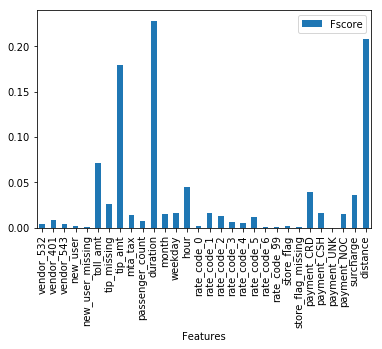

In [11]:
pd.concat([pd.DataFrame(x_train.columns, columns=['Features']), 
           pd.DataFrame(grid_search.best_estimator_.feature_importances_, columns=['Fscore'])], axis=1).set_index('Features').plot.bar()